<a href="https://colab.research.google.com/github/NaufalRAul26/EIS-T1/blob/main/UAS%20AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading Libraries

In [ ]:
#menghubungkan dengan file di drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd # Alat analisis dan manipulasi data
import numpy as np # Paket fundamental untuk aljabar linear dan array multidimensi
import tensorflow as tf # Alat pembelajaran mendalam
import os # Modul OS di Python menyediakan cara menggunakan fungsi yang bergantung pada sistem operasi
import cv2 # Pustaka untuk pemrosesan gambar
from sklearn.model_selection import train_test_split # Untuk membagi data menjadi set pelatihan dan validasi
from sklearn.metrics import f1_score, confusion_matrix # Untuk menghitung skor F1 dan menghasilkan matriks kebingungan

## Loading and preparing training data

In [ ]:
labels = pd.read_csv("/content/drive/My Drive/saindata/eye_gender_data/Training_set.csv") # loading the labels
file_paths = [[fname, '/content/drive/My Drive/saindata/eye_gender_data/train/' + fname] for fname in labels['filename']]
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
train_data = pd.merge(images, labels, how = 'inner', on = 'filename')

data = [] # initialize an empty numpy array
image_size = 100 # image size taken is 100 here. one can take other size too
for i in range(len(train_data)):
  img_array = cv2.imread(train_data['filepaths'][i], cv2.IMREAD_GRAYSCALE) # converting the image to gray scale
  new_img_array = cv2.resize(img_array, (image_size, image_size)) # resizing the image array
  data.append([new_img_array, train_data['label'][i]])

In [ ]:
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_data.head()

,filename,filepaths,label
0,Image_1.jpg,/content/drive/My Drive/saindata/eye_gender_da...,male
1,Image_2.jpg,/content/drive/My Drive/saindata/eye_gender_da...,female
2,Image_3.jpg,/content/drive/My Drive/saindata/eye_gender_da...,female
3,Image_4.jpg,/content/drive/My Drive/saindata/eye_gender_da...,female
4,Image_5.jpg,/content/drive/My Drive/saindata/eye_gender_da...,male


## Data Pre-processing

In [ ]:
train_images_gen = ImageDataGenerator(rotation_range=90, zoom_range=0.3, width_shift_range=0.3)

In [ ]:
train_images_aug = train_images_gen.flow_from_dataframe(train_data, x_col='filepaths', y_col='label')

Found 9220 validated image filenames belonging to 2 classes.


In [ ]:
X = np.array([data[i][0] for i in range(len(data))])
y = np.array([1 if data[i][1] == 'male' else 0 for i in range(len(data))])

In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training Data:", train_images.shape)
print("Testing Data:", test_images.shape)

Training Data: (7376, 100, 100)
Testing Data: (1844, 100, 100)


In [ ]:
def resize_img(img, shape=(50, 50)):
  img = cv2.resize(img, shape)
  img = np.array(img)
  return img

train_images = np.array([resize_img(img) for img in train_images]) / 255.
train_images = np.reshape(train_images, (len(train_images), 50, 50, 1))

test_images = np.array([resize_img(img) for img in test_images]) / 255.
test_images = np.reshape(test_images, (len(test_images), 50, 50, 1))
print("Training Data:", train_images.shape)
print("Testing Data:", test_images.shape)

Training Data: (7376, 50, 50, 1)
Testing Data: (1844, 50, 50, 1)


## Building Model & Hyperparameter tuning

In [ ]:
import os
from random import seed

seed_val = 42

os.environ['PYTHONHASHSEED'] = str(seed_val)
seed(seed_val)
np.random.seed(seed_val)
tf.random.set_seed(seed_val)

In [ ]:
from tensorflow.keras import layers, Sequential

In [ ]:
model = Sequential()
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(50, 50, 1), padding='valid'))
model.add(layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1)))
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='valid'))
model.add(layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1)))
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='valid'))
model.add(layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
optimizer = tf.optimizers.Adam(0.001)
model.compile(
optimizer=optimizer,
loss=tf.keras.losses.BinaryCrossentropy(),
metrics=['accuracy'],
)

history = model.fit(
train_images,
train_labels,
batch_size=50,
epochs=20,
validation_data=(test_images, test_labels)
)

Epoch 1/20
148/148 [==============================] - 129s 852ms/step - loss: 0.5706 - accuracy: 0.6880 - val_loss: 0.4742 - val_accuracy: 0.7749
Epoch 2/20
148/148 [==============================] - 115s 777ms/step - loss: 0.4156 - accuracy: 0.8235 - val_loss: 0.3611 - val_accuracy: 0.8433
Epoch 3/20
148/148 [==============================] - 118s 793ms/step - loss: 0.3537 - accuracy: 0.8517 - val_loss: 0.3139 - val_accuracy: 0.8666
Epoch 4/20
148/148 [==============================] - 116s 782ms/step - loss: 0.3088 - accuracy: 0.8727 - val_loss: 0.3130 - val_accuracy: 0.8704
Epoch 5/20
148/148 [==============================] - 113s 764ms/step - loss: 0.2718 - accuracy: 0.8899 - val_loss: 0.2563 - val_accuracy: 0.8943
Epoch 6/20
148/148 [==============================] - 121s 818ms/step - loss: 0.2617 - accuracy: 0.8940 - val_loss: 0.2717 - val_accuracy: 0.8807
Epoch 7/20
148/148 [==============================] - 117s 789ms/step - loss: 0.2273 - accuracy: 0.9093 - val_loss: 0.2607 -

<Axes: >

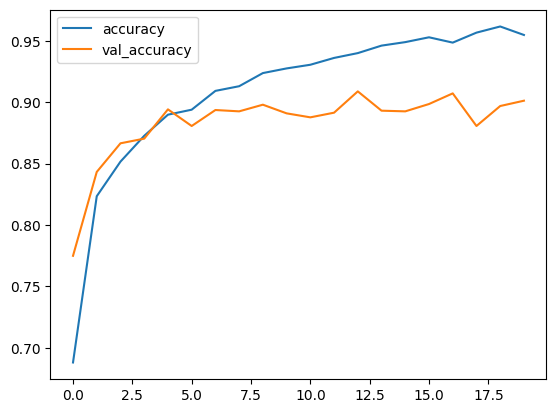

In [ ]:
history = pd.DataFrame(history.history)
history[['accuracy', 'val_accuracy']].plot()

## Validate the model

In [ ]:
model.evaluate(test_images, test_labels)

58/58 [==============================] - 7s 114ms/step - loss: 0.2975 - accuracy: 0.9013


[0.29747337102890015, 0.9013015031814575]

In [ ]:
filenames = pd.read_csv("/content/drive/My Drive/saindata/eye_gender_data/Testing_set.csv") # loading the labels
file_paths = [[fname, '/content/drive/My Drive/saindata/eye_gender_data/test/' + fname] for fname in filenames['filename']]
test_data = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])

data2 = [] # initialize an empty numpy array
for i in range(len(test_data)):
  img_array = cv2.imread(test_data['filepaths'][i], cv2.IMREAD_GRAYSCALE) # converting the image to gray scale
  data2.append(img_array)

array([[165, 175, 176, ...,  95,  94,  87],
       [150, 161, 166, ...,  88,  83,  76],
       [145, 154, 158, ...,  75,  70,  69],
       ...,
       [116, 116, 119, ..., 134, 137, 136],
       [112, 117, 123, ..., 125, 122, 118],
       [110, 116, 125, ..., 134, 128, 122]], dtype=uint8)
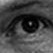

In [ ]:
data2[1]

## Predict The Output For Testing Dataset

In [ ]:
test_images = np.array([resize_img(img) for img in data2]) / 255.
test_images = np.reshape(test_images, (len(test_images), 50, 50, 1))

In [ ]:
test_images[1]

array([[[0.64705882],
        [0.68627451],
        [0.68235294],
        ...,
        [0.36862745],
        [0.36862745],
        [0.34117647]],

       [[0.58823529],
        [0.63137255],
        [0.64313725],
        ...,
        [0.3372549 ],
        [0.32156863],
        [0.29411765]],

       [[0.56470588],
        [0.6       ],
        [0.61176471],
        ...,
        [0.29019608],
        [0.2745098 ],
        [0.27058824]],

       ...,

       [[0.45490196],
        [0.45490196],
        [0.4627451 ],
        ...,
        [0.5254902 ],
        [0.54117647],
        [0.54117647]],

       [[0.43921569],
        [0.45882353],
        [0.48235294],
        ...,
        [0.49019608],
        [0.48627451],
        [0.47058824]],

       [[0.43137255],
        [0.45882353],
        [0.49019608],
        ...,
        [0.52156863],
        [0.50196078],
        [0.47843137]]])

Predict The Output For Testing Dataset

In [ ]:
predictions = model.predict(test_images)
predictions = ['male' if i == 1 else 'female' for i in np.round(predictions)]

73/73 [==============================] - 8s 112ms/step


## Save The Output To My Devices

In [ ]:
res = pd.DataFrame({'filename': test_data['filename'], 'label': predictions}) # prediction is nothing but the final predictions of your model on input features of your new unseen test data
res.to_csv("submission.csv", index = False)

# To download the csv file locally
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>